In [1]:
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import rasterio
import joblib
import lightgbm as lgb
from sklearn.metrics import mean_absolute_error

In [2]:
model_dir = 'results/models/production'
opt_dir = 'results/optimization'

lidar_path_2019 = 'data/raster/lidar_products/2019_lidar_cover.tif'
lidar_path_2020 = 'data/raster/lidar_products/2020_lidar_cover.tif'

#rap data (predictor)
rap_path = 'data/raster/rap/woody_cover_{year}.tif'

#static terrain predictors
dem_path = 'data/raster/ned/ned.tif'
slope_path = 'data/raster/terrain/slope.tif'
hli_path = 'data/raster/terrain/hli.tif'
tpi_path = 'data/raster/terrain/tpi_{ngb}.tif'
twi_path = 'data/raster/terrain/twi.tif'
covertype_path = 'data/raster/terrain/covertype.tif'

train_pts = gpd.read_file('data/vector/train_points.geojson')
train_pts['set'] = 'train'
test_pts = gpd.read_file('data/vector/test_points.geojson')
test_pts['set'] = 'test'

pts = pd.concat([train_pts, test_pts], ignore_index=True)

with rasterio.open(dem_path) as src:
    dem = [x[0] for x in src.sample([(p.x, p.y) for p in pts.geometry])]

with rasterio.open(slope_path) as src:
    slope = [x[0] for x in src.sample([(p.x, p.y) for p in pts.geometry])]

with rasterio.open(hli_path) as src:
    hli = [x[0] for x in src.sample([(p.x, p.y) for p in pts.geometry])]

with rasterio.open(twi_path) as src:
    twi = [x[0] for x in src.sample([(p.x, p.y) for p in pts.geometry])]

with rasterio.open(covertype_path) as src:
    covertype = [x[0] for x in src.sample([(p.x, p.y) for p in pts.geometry])]

Xs = {}

cover_levels = [0.0, 1.0, 2.0]
cover_names = ['upland', 'draw', 'floodplain']

X = pd.DataFrame({
    'covertype': covertype,
    'x_coord': pts.geometry.x,
    'y_coord': pts.geometry.y,
    'rap': None,
    'dem': dem, 
    'slope': slope,
    'hli': hli,
    'tpi': None,
    'twi': twi,
})


In [3]:
def rasterize_preds(template, target_path, preds, x_coords, y_coords):
    """
    Rasterize prediction points directly onto the template raster grid.
    The output raster bounds are cropped to the spatial extent of the input coordinates,
    preserving all template metadata.

    Parameters
    ----------
    template : str
        Path to the template raster file.
    target_path : str
        Path where the output raster will be saved.
    preds : array-like
        Prediction values to rasterize, length must match x_coords/y_coords.
    x_coords : array-like
        X coordinates (in same CRS as template) of the prediction points.
    y_coords : array-like
        Y coordinates (in same CRS as template) of the prediction points.
    """
    import numpy as np
    import rasterio
    from rasterio.transform import from_origin
    from rasterio.transform import rowcol  # for determining row/col from x,y coords

    # Safety check
    if len(preds) == 0 or len(x_coords) == 0 or len(y_coords) == 0:
        raise ValueError("No prediction points provided.")

    if not (len(preds) == len(x_coords) == len(y_coords)):
        raise ValueError("preds, x_coords, and y_coords must have the same length.")

    # Determine bounding XY-coords
    x_min, x_max = np.min(x_coords), np.max(x_coords)
    y_min, y_max = np.min(y_coords), np.max(y_coords)

    # Open the template and copy its metadata
    with rasterio.open(template) as src:
        meta = src.meta.copy()
        # Read the data from the first band (or whichever band is appropriate)
        data = src.read(1)
        template_transform = src.transform
        crs = src.crs

    meta['nodata'] = 255

    # Fill array with existing data or with nodata if you want a blank starting layer:
    data[:] = meta['nodata']  # Uncomment if you prefer a blank canvas

    # 1. Assign each prediction to the correct cell in the template
    for pred, x, y in zip(preds, x_coords, y_coords):
        row, col = rowcol(template_transform, x, y)
        # Check bounds
        if 0 <= row < data.shape[0] and 0 <= col < data.shape[1]:
            data[row, col] = pred
        else:
            # This point is outside the template's coverage
            print(f"Warning: ({x}, {y}) is outside the template coverage.")

    # 2. Convert your (x_min, y_max) and (x_max, y_min) to row/col for cropping
    #    because we only want the bounding box that covers x_coords/y_coords.
    #    RasterIO's rowcol expects (x, y) so we can do corners:
    upper_left_row,  upper_left_col  = rowcol(template_transform, x_min, y_max)
    lower_right_row, lower_right_col = rowcol(template_transform, x_max, y_min)

    # Because y goes top -> bottom in arrays, let's sort rows/cols properly
    row_start = min(upper_left_row, lower_right_row)
    row_stop  = max(upper_left_row, lower_right_row)
    col_start = min(upper_left_col, lower_right_col)
    col_stop  = max(upper_left_col, lower_right_col)

    # Also ensure we don't go out of the template array
    row_start = max(row_start, 0)
    col_start = max(col_start, 0)
    row_stop  = min(row_stop, data.shape[0] - 1)
    col_stop  = min(col_stop, data.shape[1] - 1)

    # 3. Slice out that window
    cropped_data = data[row_start:row_stop+1, col_start:col_stop+1]

    # 4. Update the transform to match the new spatial extent
    #    The top-left corner in terms of map units (x,y) is at (col_start, row_start).
    #    We'll use the original transform plus an offset.
    #    See https://rasterio.readthedocs.io/en/latest/topics/reproject.html#writing-out-transformed-datasets
    #    for details on updating transforms.
    origin_x, origin_y = rasterio.transform.xy(template_transform, row_start, col_start)
    pixel_width = template_transform.a
    pixel_height = template_transform.e  # typically negative if north-up

    new_transform = from_origin(origin_x, origin_y, abs(pixel_width), abs(pixel_height))
    # If your template transform's 'e' is negative (common with north-up),
    # then from_origin(...) will produce a negative downward y direction automatically.
    # Alternatively, you can do something like:
    # new_transform = Affine(pixel_width, 0, origin_x, 0, pixel_height, origin_y)
    # depending on your sign conventions.

    # 5. Update metadata
    meta.update({
        'height': cropped_data.shape[0],
        'width': cropped_data.shape[1],
        'transform': new_transform,
        'crs': crs
    })

    # 6. Write out the new cropped raster
    with rasterio.open(target_path, 'w', **meta) as dst:
        dst.write(cropped_data, 1)

def predict_year(year):
    x_coords = []
    y_coords = []
    preds = []

    for cvr in cover_levels:
        lgb_mod = joblib.load(os.path.join(model_dir, f'lgb_production_mod_{cvr}.pkl'))
        study = joblib.load(os.path.join(opt_dir, f'{cvr}', 'study.pkl'))
        params = study.best_trial.params

        focal_rap_path = rap_path.replace('{year}', str(year))
        focal_tpi_path = tpi_path.replace('{ngb}', str(params['tpi_ngb']))

        with rasterio.open(focal_rap_path) as src:
            X['rap'] = [x[0] for x in src.sample([(p.x, p.y) for p in pts.geometry])]
        
        with rasterio.open(focal_tpi_path) as src:
            X['tpi']  = [x[0] for x in src.sample([(p.x, p.y) for p in pts.geometry])]
        
        focal_d = X.copy()
        focal_d = focal_d[focal_d['covertype'] == cvr]

        #select cols: rap, dem, slope, hli, tpi, twi
        focal_X = focal_d[['rap', 'dem', 'slope', 'hli', 'tpi', 'twi']]
        focal_x_coords = focal_d['x_coord']
        focal_y_coords = focal_d['y_coord']
        #predict
        focal_preds = lgb_mod.predict(focal_X)
        preds.append(focal_preds)
        x_coords.append(focal_x_coords)
        y_coords.append(focal_y_coords)

    return np.concatenate(preds), np.concatenate(x_coords), np.concatenate(y_coords)


In [11]:
years = range(1986, 2024)
output_dir = 'data/raster/predictions'
os.makedirs(output_dir, exist_ok=True)
from joblib import Parallel, delayed

def process_year(year):
    preds, x_coords, y_coords = predict_year(year)
    rasterize_preds(lidar_path, os.path.join(output_dir, f'{year}.tif'), preds, x_coords, y_coords)

Parallel(n_jobs=-1)(delayed(process_year)(year) for year in years)

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [9]:
pred_path_2019 = 'data/raster/predictions/2019.tif'
pred_path_2020 = 'data/raster/predictions/2020.tif'
rap_path_2019 = 'data/raster/rap/woody_cover_2019.tif'
rap_path_2020 = 'data/raster/rap/woody_cover_2020.tif'

test_pts = pts[pts['set'] == 'test'].copy()
with rasterio.open(lidar_path_2019) as src:
    test_pts['lidar_2019'] = [int(x[0]) if x[0] is not None else None for x in src.sample([(p.x, p.y) for p in test_pts.geometry])]

with rasterio.open(lidar_path_2020) as src:
    test_pts['lidar_2020'] = [int(x[0]) if x[0] is not None else None for x in src.sample([(p.x, p.y) for p in test_pts.geometry])]

with rasterio.open(rap_path_2019) as src:
    test_pts['rap_2019'] = [int(x[0]) if x[0] is not None else None for x in src.sample([(p.x, p.y) for p in test_pts.geometry])]

with rasterio.open(rap_path_2020) as src:
    test_pts['rap_2020'] = [int(x[0]) if x[0] is not None else None for x in src.sample([(p.x, p.y) for p in test_pts.geometry])]

with rasterio.open(pred_path_2019) as src:
    test_pts['pred_2019'] = [int(x[0]) if x[0] is not None else None for x in src.sample([(p.x, p.y) for p in test_pts.geometry])]

with rasterio.open(pred_path_2020) as src:
    test_pts['pred_2020'] = [int(x[0]) if x[0] is not None else None for x in src.sample([(p.x, p.y) for p in test_pts.geometry])]

with rasterio.open(covertype_path) as src:
    test_pts['covertype'] = [int(x[0]) if x[0] is not None else None for x in src.sample([(p.x, p.y) for p in test_pts.geometry])]

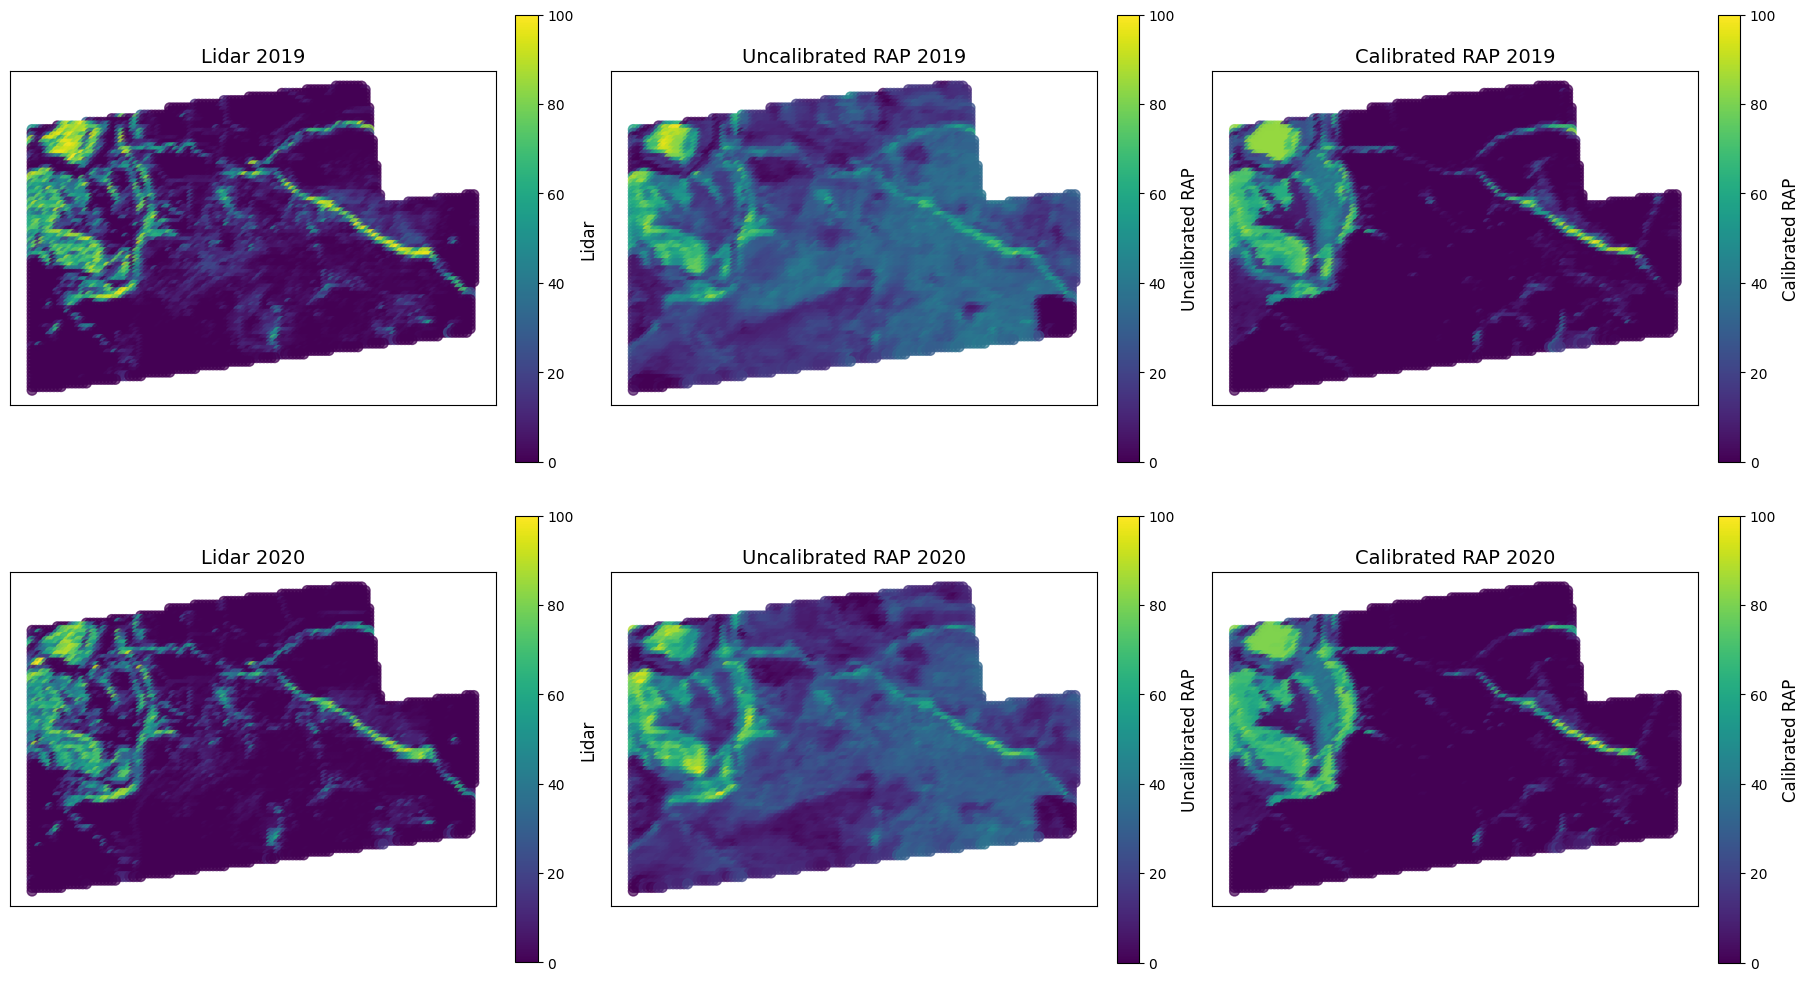

In [10]:
# Define the years and variables to plot
years = [2019, 2020]
variables = ['lidar', 'rap', 'pred']
variable_labels = {
    'lidar': 'Lidar',
    'rap': 'Uncalibrated RAP',
    'pred': 'Calibrated RAP'
}

# Create a 2x3 subplot
fig, axes = plt.subplots(len(years), len(variables), figsize=(18, 10),
                         subplot_kw={'aspect': 'equal'}, constrained_layout=True)

for row, year in enumerate(years):
    for col, var in enumerate(variables):
        ax = axes[row, col]
        
        # Define the column to plot
        column = f'{var}_{year}'
        
        # Plot the points, colored by the variable
        scatter = test_pts.plot(column=column, ax=ax, cmap='viridis',
                                markersize=50, alpha=0.7, legend=False)
        
        # Add a colorbar
        norm = colors.Normalize(vmin=0, vmax=100)
        sm = plt.cm.ScalarMappable(cmap='viridis', norm=norm)
        sm.set_array([])
        cbar = fig.colorbar(sm, ax=ax, fraction=0.046, pad=0.04)
        cbar.set_label(variable_labels[var], fontsize=12)
        
        # Set titles and labels
        if row == 0:
            ax.set_title(f'{variable_labels[var]} {year}', fontsize=14)
        if row == 1:
            ax.set_title(f'{variable_labels[var]} {year}', fontsize=14)
        if col == 0:
            ax.set_ylabel(f'Year {year}\nX Coordinate', fontsize=12)
        
        # Remove axis ticks and labels for a cleaner look
        ax.set_xlabel('')
        ax.set_ylabel('')
        ax.set_xticks([])
        ax.set_yticks([])
        
        # Optional: Add grid
        ax.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.5)

plt.show()

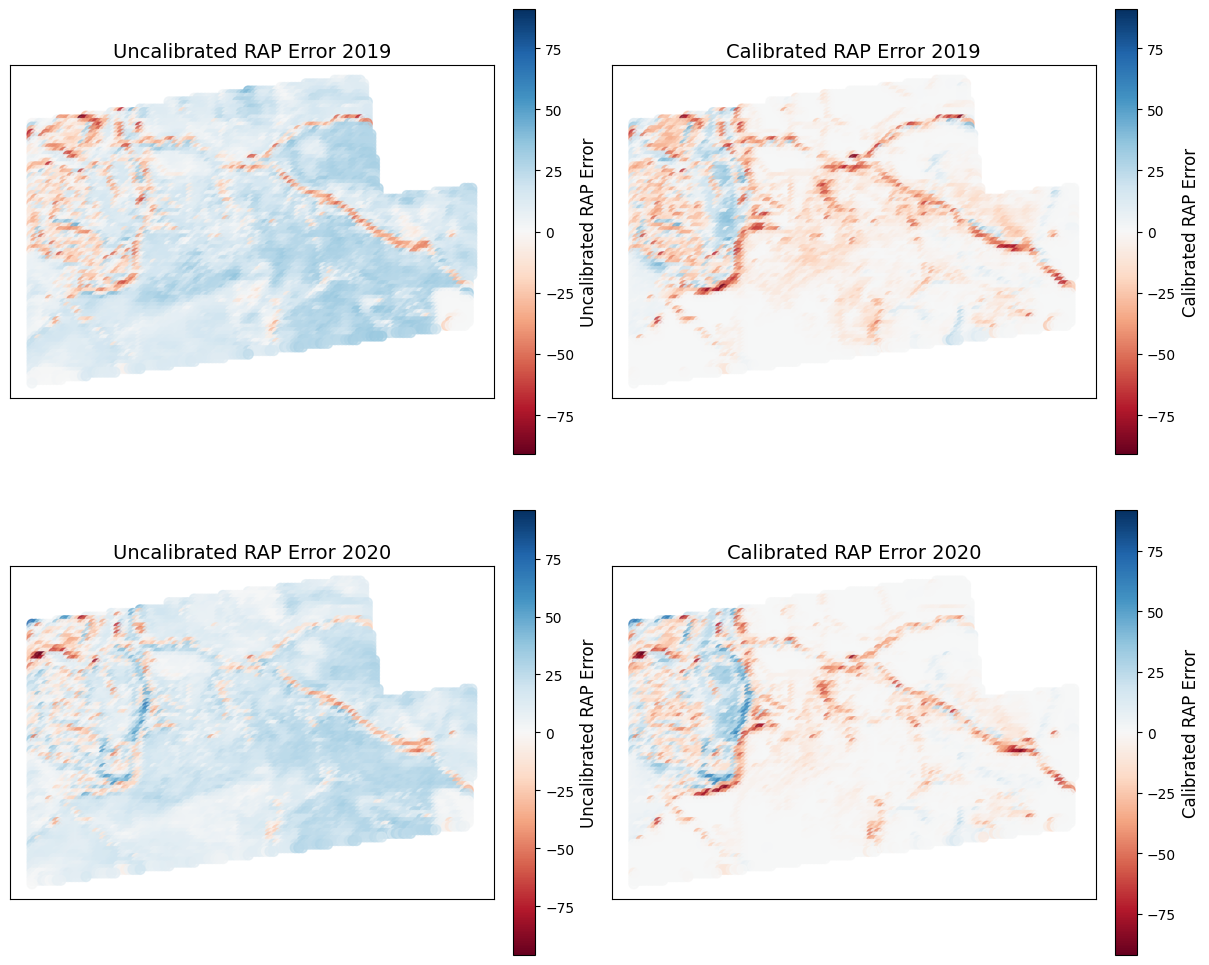

In [19]:
test_pts['diff_rap_2019'] = test_pts['rap_2019'] - test_pts['lidar_2019']
test_pts['diff_pred_2019'] = test_pts['pred_2019'] - test_pts['lidar_2019']
test_pts['diff_rap_2020'] = test_pts['rap_2020'] - test_pts['lidar_2020']
test_pts['diff_pred_2020'] = test_pts['pred_2020'] - test_pts['lidar_2020']

# Define the years and variables to plot
years = [2019, 2020]
variables = ['diff_rap', 'diff_pred']
variable_labels = {
    'diff_rap': 'Uncalibrated RAP Error',
    'diff_pred': 'Calibrated RAP Error'
}

# Create a 2x2 subplot
fig, axes = plt.subplots(len(years), len(variables), figsize=(12, 10),
                         subplot_kw={'aspect': 'equal'}, constrained_layout=True)

for row, year in enumerate(years):
    for col, var in enumerate(variables):
        ax = axes[row, col]
        
        # Define the column to plot
        column = f'{var}_{year}'
        
        # Determine min and max for symmetric colorbar
        vmin = test_pts[column].min()
        vmax = test_pts[column].max()
        v_absmax = max(abs(vmin), abs(vmax))
        
        # Plot the points, colored by the variable
        scatter = test_pts.plot(column=column, ax=ax, cmap='RdBu',  # Divergent colormap
                                vmin=-v_absmax, vmax=v_absmax,  # Symmetric colorbar
                                markersize=50, alpha=0.7, legend=False)
        
        # Add a colorbar
        norm = colors.Normalize(vmin=-v_absmax, vmax=v_absmax)
        sm = plt.cm.ScalarMappable(cmap='RdBu', norm=norm)
        sm.set_array([])
        cbar = fig.colorbar(sm, ax=ax, fraction=0.046, pad=0.04)
        cbar.set_label(variable_labels[var], fontsize=12)
        
        # Set titles and labels
        if row == 0:
            ax.set_title(f'{variable_labels[var]} {year}', fontsize=14)
        if row == 1:
            ax.set_title(f'{variable_labels[var]} {year}', fontsize=14)
        if col == 0:
            ax.set_ylabel(f'Year {year}\nX Coordinate', fontsize=12)
        
        # Remove axis ticks and labels for a cleaner look
        ax.set_xlabel('')
        ax.set_ylabel('')
        ax.set_xticks([])
        ax.set_yticks([])
        
        # Optional: Add grid
        ax.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.5)

plt.show()

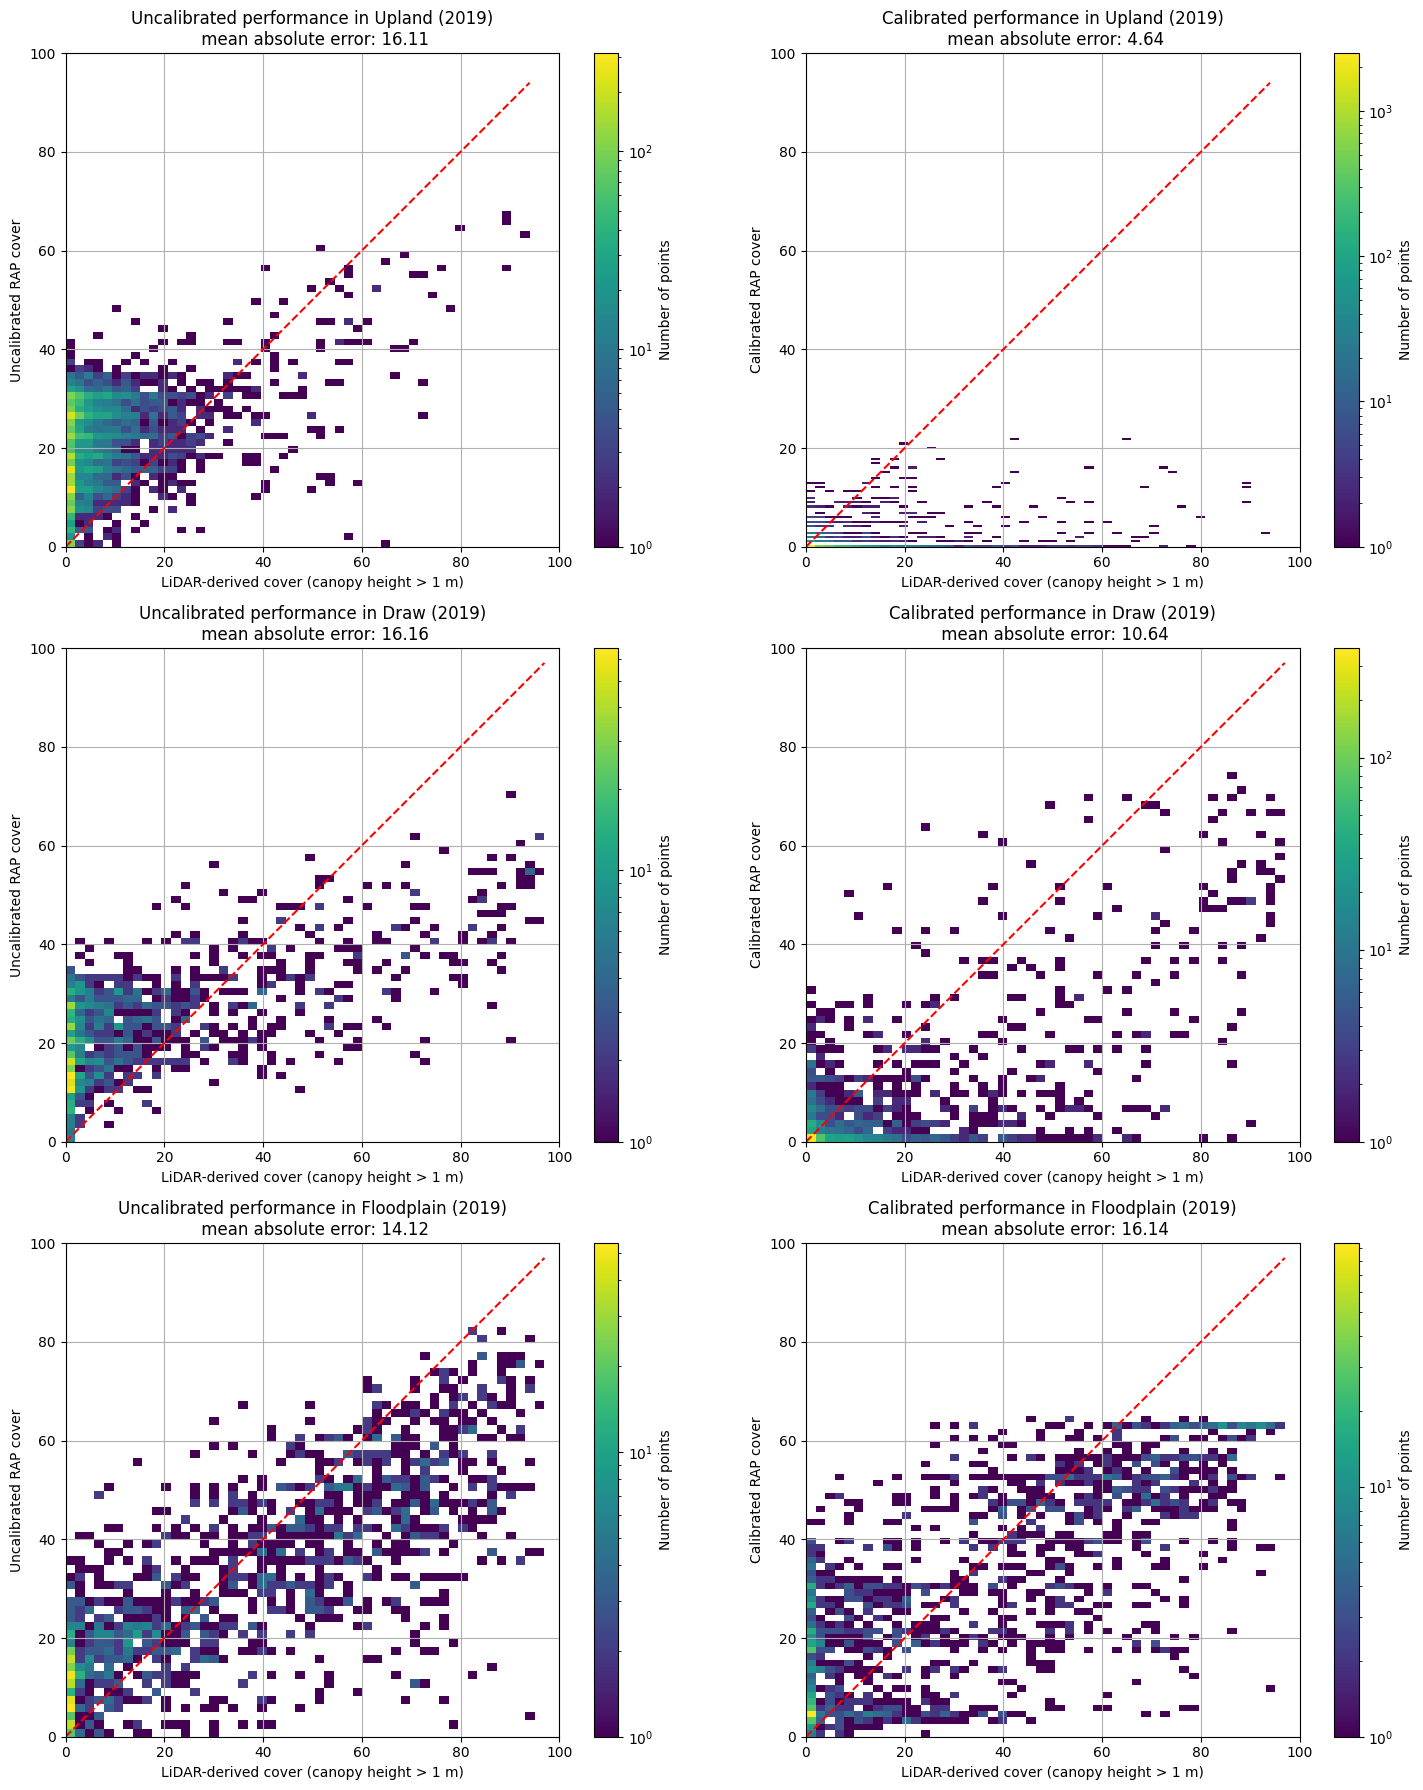

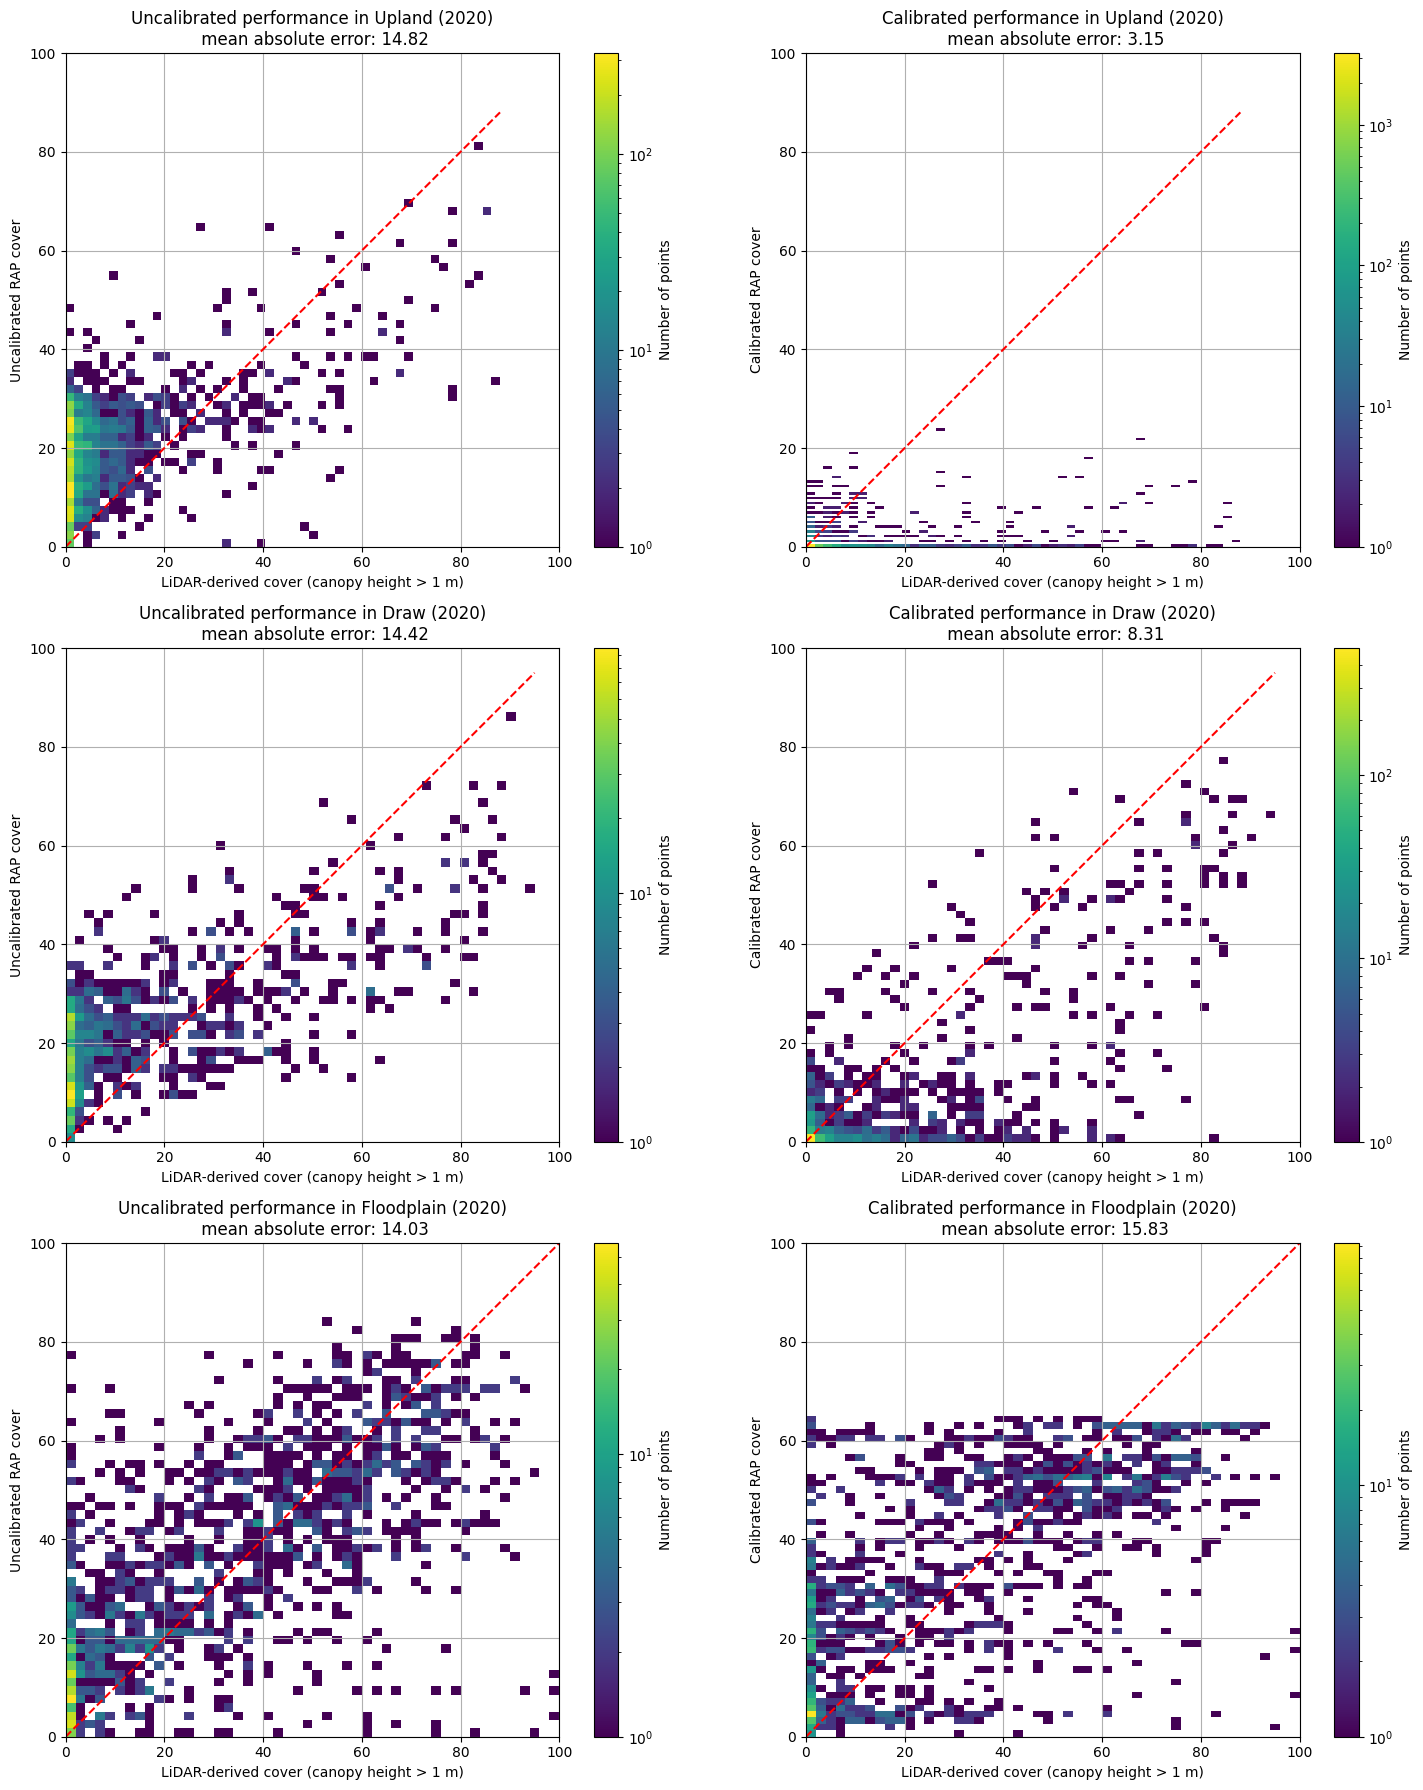

In [24]:
fig, axes = plt.subplots(3, 2, gridspec_kw={'width_ratios': [1, 1]}, figsize=(15, 18))
cover_types = [0, 1, 2]
cover_type_names = ['Upland', 'Draw', 'Floodplain']
years = [2019, 2020]

for i, cover_type in enumerate(cover_types):
    df_subset = test_pts[test_pts['covertype'] == cover_type]
    focal_name = cover_type_names[i]

    # Uncalibrated RAP vs LiDAR (2019)
    h = axes[i, 0].hist2d(
        df_subset[f'lidar_{years[0]}'], 
        df_subset[f'rap_{years[0]}'], 
        bins=50, cmap='viridis', norm=colors.LogNorm()
    )
    cbar = plt.colorbar(h[3], ax=axes[i, 0])
    cbar.ax.set_ylabel('Number of points')
    score_rap_lidar = mean_absolute_error(
        df_subset[f'lidar_{years[0]}'], 
        df_subset[f'rap_{years[0]}']
    )
    axes[i, 0].set_xlabel(f'LiDAR-derived cover (canopy height > 1 m)')
    axes[i, 0].set_ylabel('Uncalibrated RAP cover')
    axes[i, 0].set_title(f'Uncalibrated performance in {focal_name} ({years[0]})\n mean absolute error: {score_rap_lidar:.2f}')
    axes[i, 0].grid(True)
    min_val = min(min(df_subset[f'lidar_{years[0]}']), min(df_subset[f'rap_{years[0]}']))
    max_val = max(max(df_subset[f'lidar_{years[0]}']), max(df_subset[f'rap_{years[0]}']))
    axes[i, 0].plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--')
    axes[i, 0].set_aspect('equal', adjustable='box')
    axes[i, 0].set_xlim(0, 100)
    axes[i, 0].set_ylim(0, 100)

    # Calibrated RAP vs LiDAR (2019)
    h = axes[i, 1].hist2d(
        df_subset[f'lidar_{years[0]}'], 
        df_subset[f'pred_{years[0]}'], 
        bins=50, cmap='viridis', norm=colors.LogNorm()
    )
    cbar = plt.colorbar(h[3], ax=axes[i, 1])
    cbar.ax.set_ylabel('Number of points')
    score_pred_lidar = mean_absolute_error(
        df_subset[f'lidar_{years[0]}'], 
        df_subset[f'pred_{years[0]}']
    )
    axes[i, 1].set_xlabel(f'LiDAR-derived cover (canopy height > 1 m)')
    axes[i, 1].set_ylabel('Calibrated RAP cover')
    axes[i, 1].set_title(f'Calibrated performance in {focal_name} ({years[0]})\n mean absolute error: {score_pred_lidar:.2f}')
    axes[i, 1].grid(True)
    min_val = min(min(df_subset[f'lidar_{years[0]}']), min(df_subset[f'pred_{years[0]}']))
    max_val = max(max(df_subset[f'lidar_{years[0]}']), max(df_subset[f'pred_{years[0]}']))
    axes[i, 1].plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--')
    axes[i, 1].set_aspect('equal', adjustable='box')
    axes[i, 1].set_xlim(0, 100)
    axes[i, 1].set_ylim(0, 100)

# Show the plot
plt.tight_layout()
plt.show()

fig, axes = plt.subplots(3, 2, figsize=(15, 18))
cover_types = [0, 1, 2]
cover_type_names = ['Upland', 'Draw', 'Floodplain']
years = [2019, 2020]

for i, cover_type in enumerate(cover_types):
    df_subset = test_pts[test_pts['covertype'] == cover_type]
    focal_name = cover_type_names[i]

    # Uncalibrated RAP vs LiDAR (2020)
    h = axes[i, 0].hist2d(
        df_subset[f'lidar_{years[1]}'], 
        df_subset[f'rap_{years[1]}'], 
        bins=50, cmap='viridis', norm=colors.LogNorm()
    )
    cbar = plt.colorbar(h[3], ax=axes[i, 0])
    cbar.ax.set_ylabel('Number of points')
    score_rap_lidar = mean_absolute_error(
        df_subset[f'lidar_{years[1]}'], 
        df_subset[f'rap_{years[1]}']
    )
    axes[i, 0].set_xlabel(f'LiDAR-derived cover (canopy height > 1 m)')
    axes[i, 0].set_ylabel('Uncalibrated RAP cover')
    axes[i, 0].set_title(f'Uncalibrated performance in {focal_name} ({years[1]})\n mean absolute error: {score_rap_lidar:.2f}')
    axes[i, 0].grid(True)
    min_val = min(min(df_subset[f'lidar_{years[1]}']), min(df_subset[f'rap_{years[1]}']))
    max_val = max(max(df_subset[f'lidar_{years[1]}']), max(df_subset[f'rap_{years[1]}']))
    axes[i, 0].plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--')
    axes[i, 0].set_aspect('equal', adjustable='box')
    axes[i, 0].set_xlim(0, 100)
    axes[i, 0].set_ylim(0, 100)

    # Calibrated RAP vs LiDAR (2020)
    h = axes[i, 1].hist2d(
        df_subset[f'lidar_{years[1]}'], 
        df_subset[f'pred_{years[1]}'], 
        bins=50, cmap='viridis', norm=colors.LogNorm()
    )
    cbar = plt.colorbar(h[3], ax=axes[i, 1])
    cbar.ax.set_ylabel('Number of points')
    score_pred_lidar = mean_absolute_error(
        df_subset[f'lidar_{years[1]}'], 
        df_subset[f'pred_{years[1]}']
    )
    axes[i, 1].set_xlabel(f'LiDAR-derived cover (canopy height > 1 m)')
    axes[i, 1].set_ylabel('Calibrated RAP cover')
    axes[i, 1].set_title(f'Calibrated performance in {focal_name} ({years[1]})\n mean absolute error: {score_pred_lidar:.2f}')
    axes[i, 1].grid(True)
    min_val = min(min(df_subset[f'lidar_{years[1]}']), min(df_subset[f'pred_{years[1]}']))
    max_val = max(max(df_subset[f'lidar_{years[1]}']), max(df_subset[f'pred_{years[1]}']))
    axes[i, 1].plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--')
    axes[i, 1].set_aspect('equal', adjustable='box')
    axes[i, 1].set_xlim(0, 100)
    axes[i, 1].set_ylim(0, 100)

# Show the plot
plt.tight_layout()
plt.show()